In [4]:
# Project description
#
# The aim of this notebook is to explore and find ways to predict heart disease with as high performance as possible
# using the "UCI Heart Disease" dataset, extracted from Kaggle.com.
# -------------------------

import pandas as pd
import numpy as np

data = pd.read_csv('dataset.csv', sep = ',')


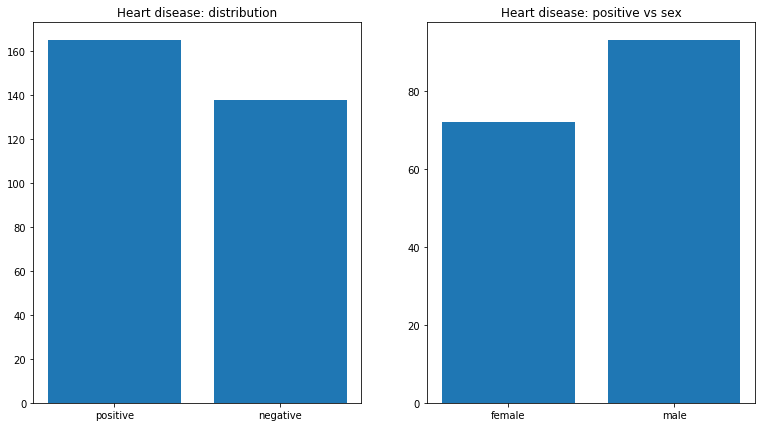

sex  target
0    0          24
     1          72
1    0         114
     1          93
Name: target, dtype: int64

In [85]:
# Testing some shit
import matplotlib.pyplot as plt

names = ['positive', 'negative']
sex = ['female', 'male']

plt.figure(1, figsize=(20, 7))

plt.subplot(131)
plt.bar(names, data['target'].value_counts())
plt.title('Heart disease: distribution')
plt.subplot(132)
# Plotting male and female counts for cases that are positive with heart disease
# Conclusion: the positive cases are reasonably equally distributed
# = negative cases aren't
plt.bar(sex, data[data.target == 1].groupby(['sex'])['target'].count())
plt.title('Heart disease: positive vs sex')
plt.show()

# Male = 1, female 0
# Positive heart disease = 1, negative heart disease = 0
data.groupby(['sex', 'target'])['target'].count()
# Data for females is skewed towards positive cases

In [86]:
# checking distribution for male/female for different levels of chest pain
# chest pain description:
# 9 cp: chest pain type
# -- Value 1: typical angina
# -- Value 2: atypical angina
# -- Value 3: non-anginal pain
# -- Value 4: asymptomatic  
# Therefore, we come to the conclusion:
# For males, the data strongly suggests that there could be predictive power in classifying males as not having heart disease if the chest pain type is typical angina 
pd.crosstab([data['sex'],data['target']],data.cp,margins=True).style.background_gradient(cmap='summer_r')

In [62]:
# checking the first few rows to get a feel for the contents of the dataset 
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [34]:
# checking distribution between positive and negative subjects in the dataset
data.target.value_counts()

1    165
0    138
Name: target, dtype: int64

In [4]:
# checking for duplicate rows
data.duplicated().value_counts()
# one duplicate row found, drop it
data = data.drop_duplicates()

In [5]:
# no null cells for any feature
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
## -------------------------------------------------
## Create model using random forest algorithm, evaluate using accuracy
## -------------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as rf

# Split data into test (25%), train (75%) and corresponding labels
x_train, x_test, y_train, y_test  = train_test_split(data.drop('target', 1), data['target'], test_size = 0.25)

# Forest of 50 trees
model = rf(n_estimators=50)
model = model.fit(x_train, y_train)
# Create predictions
pred = model.predict(x_test)
# Calculate accuracy using above model
(pred == y_test).sum()/y_test.size


0.7763157894736842

In [7]:
## -------------------------------------------------
## Using cross validation + AUC instead of accuracy
## -------------------------------------------------

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold


rf = RandomForestClassifier(n_estimators=100,criterion="entropy")   
cv = StratifiedKFold(n_splits=10)
# holding true positives
tprs = []
# holding auc scores
aucs = []
# create ndarray with 
mean_fpr = np.linspace(0, 1, 100)

class_labels = data['target'].reset_index(drop=True)
data_no_cl = data.drop('target', axis = 1)

for train, test in cv.split(data_no_cl, class_labels):
    model = rf.fit(data_no_cl.iloc[train], class_labels[train])
    pred = model.predict(data_no_cl.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(class_labels[test], pred)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
        
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
print(mean_auc)

0.8219001820578247
